# Booking.com predicting sellouts

The purpose of this notebook is to outline a model which predicts when a given hotel will sell out
for a specified date.

The outline of this notebook is as follows:

### 1) Model 1 - Linear regression <br>
1.1) Fake data generation<br>
1.2) Model training<br>
1.3 Performance evaluation<br>
### 2) Model 2 - Poisson regression<br>
2.1) Fake data generation<br>
2.2) Model training<br>
2.3) Performance evaluation<br>


In [51]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
pd.set_option('display.max_columns', 500)
%matplotlib inline

# Simulated Data

In this section we generate simulated data for the sake of demonstrating how we could train and validate a model. We use 5 features for this basic model:


1) The number of rooms booked at the hotel in the past week.

2) The rating of the hotel.

3) The average price per night.

4) The number of sell outs the hotel has had in the past year.

5) The location rating.

**Our goal on day $t$ is to predict the number of hotel rooms that will be available on day $t+1$, $t+2$, ... up to $t+5$.**


In [52]:
size=100000

purchase_velocity_lastweek = nprnd.randint(0,500,size=size)

hotel_rating = nprnd.randint(1,100,size=size).astype(float)/10

price_per_night_avg = nprnd.randint(100,600,size=size)

sellouts_total = nprnd.randint(1,10,size=size)

location = nprnd.randint(1,100,size=size).astype(float)/10

rooms_left = nprnd.randint(1,500,size=size)

account_num = nprnd.randint(1,100000,size=size)
date='2015-06-01'

In [53]:
df = pd.DataFrame({'hotel_rating':hotel_rating, 'location':location, 'price_per_night_avg':price_per_night_avg,'purchase_velocity_lastweek':purchase_velocity_lastweek,'rooms_left':rooms_left})

In [54]:
df.head()

,hotel_rating,location,price_per_night_avg,purchase_velocity_lastweek,rooms_left
0,9.4,1.9,287,179,448
1,3.7,9.0,206,366,449
2,9.1,3.0,293,18,193
3,6.2,3.7,199,249,362
4,0.8,1.2,553,354,209


# 1) Model 1 - Linear Regression

We now generate the number of rooms left tomorrow as a linear function of the above features, but add in some Gaussian noise to 
the data to make it more realistic. 

$$ \hat y = \alpha_0 X_{t-1} + \alpha_1 R + \alpha_2 S + \alpha_3 P + \alpha_4 L $$

$X_{t-1}$ is the number of rooms booked last week

$ R $ is the raiting of the hotel 

$ S $ is the number of sellouts the hotel had last year

$ P $ is the price of the room

$ L $ is the location rating

$ \hat y $ is the number of rooms that will be booked tomorrow


A more advanced model would be 

$$ \hat y_h = \alpha_k^h + \alpha_1 R + \alpha_2 S + \alpha_3 P + \alpha_4 L, $$

where each hotel has its own coefficientsf for the AR component. 




### 1.1). Add Gaussian noise to simulated data.

We write $$ \hat y = \alpha_0 X_{t-1} + \alpha_1 R + \alpha_2 S + \alpha_3 P + \alpha_4 L + N$$ where $N$ is sampled from a Guassian distribution. 

In [55]:
rooms_sold = (0.9*purchase_velocity_lastweek + 0.8*hotel_rating + 0.7*sellouts_total + 0.6*price_per_night_avg + 0.4*location)/10
#rooms_sold = 20*hotel_rating
noise = np.random.normal(0,8,size)

rooms_sold=rooms_sold+noise

In [43]:
#df = pd.DataFrame({'account': account_num, 'date':date, 'purchase_velocity_lastweek':purchase_velocity_lastweek, 'hotel_rating':hotel_rating,
  #                 'price_per_night_avg':price_per_night_avg,'sellouts_total':sellouts_total,'location':location,'rooms_left':rooms_left})

In [56]:
df

,hotel_rating,location,price_per_night_avg,purchase_velocity_lastweek,rooms_left
0,9.4,1.9,287,179,448
1,3.7,9.0,206,366,449
2,9.1,3.0,293,18,193
3,6.2,3.7,199,249,362
4,0.8,1.2,553,354,209
5,3.0,4.7,116,406,227
6,4.1,7.5,481,23,289
7,3.9,3.4,128,426,261
8,1.9,5.7,175,301,203
9,0.5,1.5,447,81,286


In [57]:
# X are features and y is predictive variable
X = df
y=rooms_sold

# Scale columns for regression.
#scaler = StandardScaler()
#X = X.as_matrix().astype(np.float)
#X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape

Feature space holds 100000 observations and 5 features


In [46]:
df.head() # would you need 365 entries per hotel?

,hotel_rating,location,price_per_night_avg,purchase_velocity_lastweek,rooms_left
0,5.9,4.1,333,484,450
1,5.8,5.3,392,136,79
2,9.6,0.5,236,492,206
3,4.1,8.0,273,144,79
4,7.6,9.6,457,83,76


### 2. Split into training and testing data and evaluate model on testing data

In [58]:
# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

('Coefficients: \n', array([  8.40738291e-02,   3.49690739e-02,   6.02044895e-02,
         8.96639273e-02,   9.22163141e-05]))
Residual sum of squares: 62.84
Variance score: 0.79


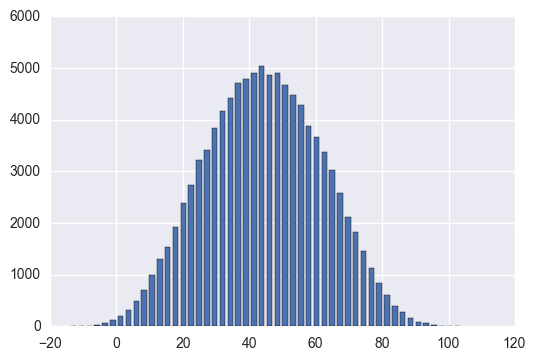

In [59]:
hist, bins = np.histogram(rooms_sold, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### 3. Plot Predictions on Testing Data vs Reality

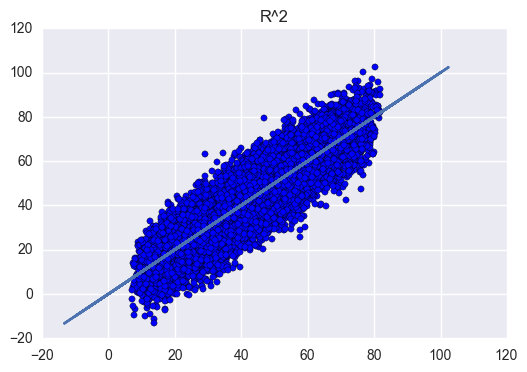

In [67]:
#plt.figure(figsize=(10,10))
plt.title('R^2')
plt.scatter(regr.predict(X_test),y_test)
plt.plot(y_test,y_test)

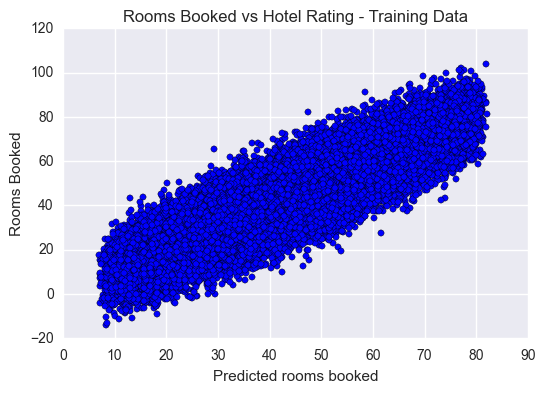

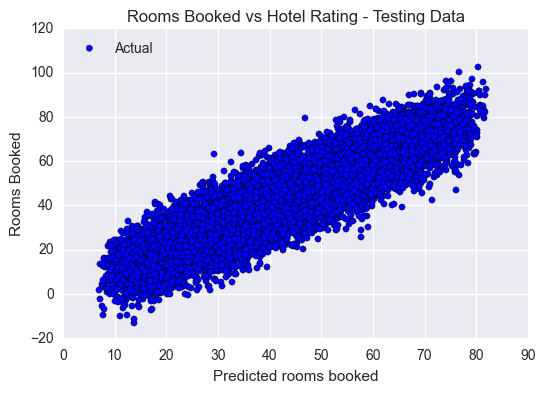

In [65]:
plt.ylabel('Rooms Booked')
plt.xlabel('Predicted rooms booked')
plt.title('Rooms Booked vs Hotel Rating - Training Data')
plt.scatter(regr.predict(X_train),y_train)
plt.show()
plt.ylabel('Rooms Booked')
plt.xlabel('Predicted rooms booked')
plt.title('Rooms Booked vs Hotel Rating - Testing Data')
plt.scatter(regr.predict(X_test),y_test,label='Actual')
#plt.plot(X_test['hotel_rating'],regr.predict(X_test),color='r',label='Predicted')
plt.legend(loc=2)
plt.show()

### 4. Predict for days into the future. 

In [637]:
day1_predictions=regr.predict(X_test)
X_test.loc[:,'purchase_velocity_lastweek'] += day1_predictions
day2_predictions=regr.predict(X_test)
X_test.loc[:,'purchase_velocity_lastweek'] += day2_predictions
day3_predictions=regr.predict(X_test)
X_test.loc[:,'purchase_velocity_lastweek'] += day3_predictions

In [638]:
X_test.loc[:,'day1']=day1_predictions
X_test.loc[:,'day2']=day2_predictions
X_test.loc[:,'day3']=day3_predictions

def get_sellout_time(row):
    
    if row['day1']> row['rooms_left']:
        return 1
    elif row['day2'] > row['rooms_left']:
        return 2
    elif row['day3'] > row['rooms_left']:
        return 3
    else:
        return -1

X_test.loc[:,'sellout_days']=X_test.apply(lambda row : get_sellout_time(row),axis=1)

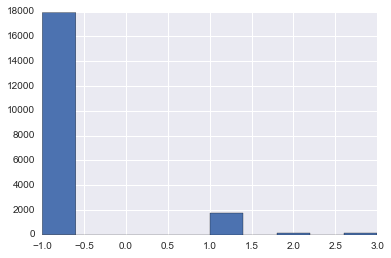

In [639]:
X_test['sellout_days'].hist()

# Model 2 - Poisson Regression 

Since the event of booking a room is a low probability event given the number of people who see the room (most likely), the events are indepedent, and it is count data, it could be better modeled as a Poisson distribution.

$$ \log \mathbb E(y | x) = \alpha + \beta \cdot x $$

$$ Y_{t+1} \sim \textrm{Pois}(\mathbb E(y | x_{t} )) $$

We assume here that:

$$ \log \mathbb{E} (y_t | x) = 0.01 X_{t-1} $$.

Additionally it also makes more sense to assume that $ \log \mathbb E(y | x) $ is non-negative. 

### 2.1) Generated simulated data

In [575]:
import numpy as np
from scipy.stats import nbinom
from scipy.stats import poisson

In [576]:
# Poisson Loglikliehood
def _ll_nb2(y, X,beta):
     mu = np.exp(np.dot(X,beta))
     ll = poisson.logpmf(y, mu)
     return ll

In [577]:
# Simple linear model 
rooms_sold_lambdas =np.exp( 0.01*purchase_velocity_lastweek ) 
rooms_sold=np.random.poisson(rooms_sold_lambdas)

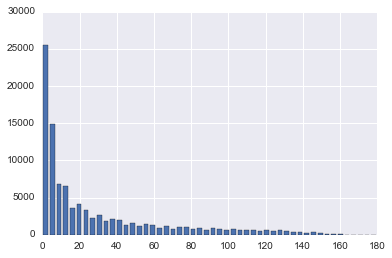

In [578]:
hist, bins = np.histogram(rooms_sold, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### 2. Split into training and testing data and evaluate model on testing data

In [579]:
# Time series
y=rooms_sold
X=df

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

In [580]:
from statsmodels.base.model import GenericLikelihoodModel
class NBin(GenericLikelihoodModel):
     def __init__(self, endog, exog, **kwds):
         super(NBin, self).__init__(endog, exog, **kwds)
     def nloglikeobs(self, params): 
         ll = _ll_nb2(self.endog, self.exog, params)
         return -ll
     def fit(self, start_params=None, maxiter=100000, maxfun=5000, **kwds):
         if start_params == None:
             # Reasonable starting values
             start_params = [0.001,0,0,0,0,0]
             start_params[0] = np.log(self.endog.mean())
         return super(NBin, self).fit(start_params=start_params,
                                      maxiter=maxiter, maxfun=maxfun,
                                      **kwds)
     def predict(self,exog):
         print 'hello'
         return super(NBin,self).predict(exog)

mod = NBin(y_train, X_train)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 2.651991
         Iterations: 234
         Function evaluations: 384


### 3. Evaluate performance in terms of $R^2$ 

In [593]:
predictions = np.exp(np.dot(X_test.values,res.params))

In [604]:
SSreg = np.mean((predictions - y_test) ** 2)
SStot =  np.mean((y_test - np.mean(y_test)) ** 2)
print 1 - SSreg/SStot

0.975778913506


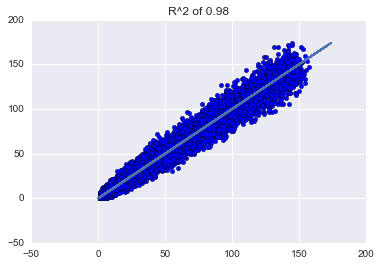

In [606]:
r2 = (predictions - np.sum(()))
plt.title('R^2 of 0.98')
plt.plot(y_test,y_test)
plt.scatter(predictions, y_test)

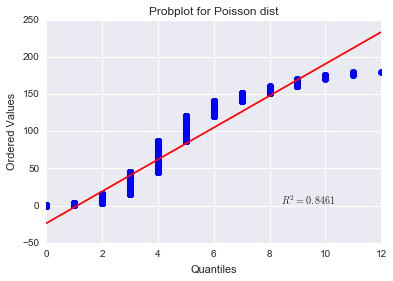

In [607]:
fig = plt.figure()
mu=np.mean(learned)
ax = fig.add_subplot(111)
x = stats.loggamma.rvs(c=2.5, size=500)
stats.probplot(y, dist=stats.poisson, sparams=(mu), plot=ax)
ax.set_title("Probplot for Poisson dist")

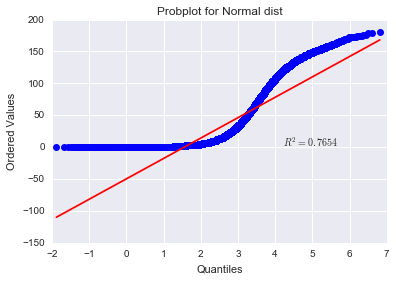

In [608]:
fig = plt.figure()
mu=np.mean(learned)
ax = fig.add_subplot(111)
x = stats.loggamma.rvs(c=2.5, size=500)
stats.probplot(y, dist=stats.norm, sparams=(mu), plot=ax)
ax.set_title("Probplot for Normal dist")

# How would raw data be converted to this form?

In [117]:
# Predict number sold in next day, then day after that, etc.

In [356]:
# SQL example
dates = pd.date_range('2016-01-01', '2016-01-07', freq='H')

In [357]:
df_t = pd.DataFrame({'account':accounts},index=dates)

In [358]:
accounts = nprnd.randint(0,5,size=145)

In [354]:
#purchase_velocity_lastweek = nprnd.randint(0,500,size=size)
size=145
hotel_rating = nprnd.randint(1,100,size=size).astype(float)/10
price_per_night = nprnd.randint(100,600,size=size)
rooms_sold = nprnd.randint(1,10,size=size)
location = nprnd.randint(1,100,size=size).astype(float)/10
rooms_left = nprnd.randint(1,500,size=size)

In [400]:
def hotel_info(account):
    # rating, price, soldsofar, location, roomsleft
    if account== 0:
        return 10, 200, 40, 8, 9
    elif account== 1:
        return 9, 300, 30, 7, 8
    elif account== 2:
        return 8, 400, 20, 5, 7
    elif account== 3:
        return 7, 500, 10, 6, 6
    elif account== 4:
        return 6, 600, 40, 4, 0
    
rating = [hotel_info(account)[0] + np.random.randint(1,2) for account in accounts]
price = [hotel_info(account)[1] + np.random.randint(0,1) for account in accounts]
#sold = [hotel_info(account)[2] for account in accounts]
location = [hotel_info(account)[3] for account in accounts]
#left = [hotel_info(account)[4] for account in accounts]

In [401]:
df_t = pd.DataFrame({'account':accounts,'rating':rating,'price':price,'location':location,'userid':range(0,len(df_t))},index=dates)

In [398]:
df_t.head()

,account,location,price,rating,userid
2016-01-01 00:00:00,2,5,400,8,0
2016-01-01 01:00:00,4,4,600,6,1
2016-01-01 02:00:00,2,5,400,8,2
2016-01-01 03:00:00,4,4,600,6,3
2016-01-01 04:00:00,2,5,400,8,4


In [402]:
print df_t.groupby('account')['rating'].mean()
print df_t.groupby('account').size()

account
0    11
1    10
2     9
3     8
4     7
Name: rating, dtype: int64
account
0    23
1    27
2    37
3    25
4    33
dtype: int64
